## Calculate the background NPP

In [1]:
# --------------------------------------------------------
# import necessary packages
# --------------------------------------------------------
from matplotlib import pyplot as plt
import pandas as pd
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
import xarray as xr
from datetime import datetime
import numpy as np
from netCDF4 import Dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
# separation distance between coastal and non-coastal domain
d_coast = 700. 
# month of analysis, March to September
mon = [1,2,3,4,5,6,7,8,9,10,11,12]

In [3]:
fn = 'distance_from_nearest_land.nc'
dm=xr.open_dataset(fn)

In [4]:
# --------------------------------------------------------
# select date and domain of the NPP data
# display the analysis domain
# --------------------------------------------------------
ds1=xr.open_dataset('~/project36/obs/npp_CbPM-MODIS_8day_GOA.nc')

In [5]:
# calculate monthly mean climatology of NPP
npp_clim = ds1.npp.groupby('time.month').mean('time')
ds2=npp_clim.to_dataset()

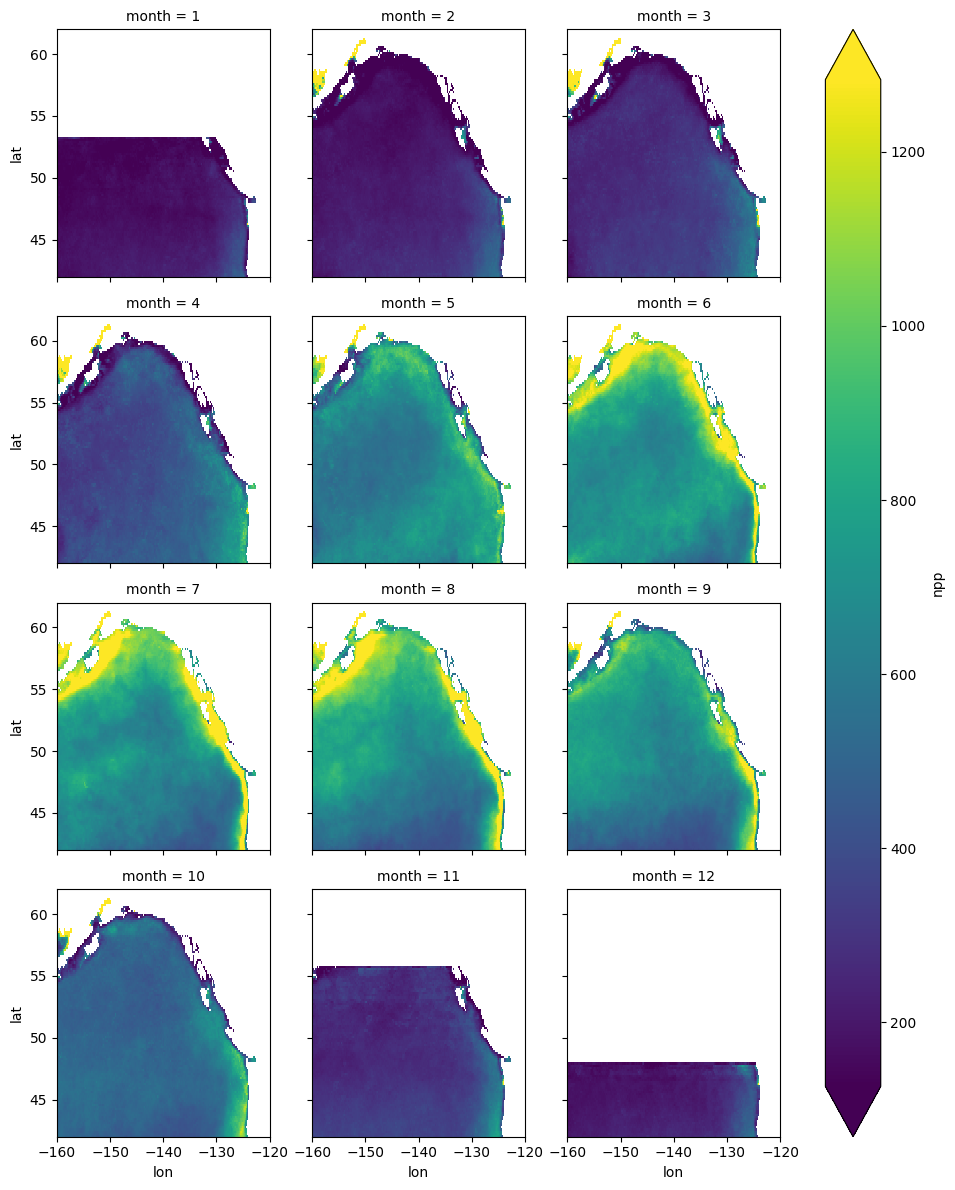

In [6]:
# display the climatology
ds2.npp.plot(x="lon", y="lat", col="month", col_wrap=3, robust=True)
x=ds2.lon.to_numpy()
y=ds2.lat.to_numpy()

In [7]:
# make the distance field on the same grid as the NPP climatology
d_remap = dm.distance.interp(lon=x+360,lat=y).to_numpy()
mask_coastal = np.where(d_remap <= 700,1,0)
mask_noncoastal = np.where(d_remap > 700,1,0)
#
d_coastal = xr.DataArray(data=mask_coastal,name='mask_coastal',dims=['lat','lon'],coords={'lat':y,'lon':x})
d_noncoastal = xr.DataArray(data=mask_noncoastal,name='mask_noncoastal',dims=['lat','lon'],coords={'lat':y,'lon':x})

In [8]:
# weight NPP by the coastal / non-coastal mask and take domain average
npp_coastal = ds2.npp.weighted(d_coastal).mean('lat').mean('lon')
npp_noncoastal = ds2.npp.weighted(d_noncoastal).mean('lat').mean('lon')

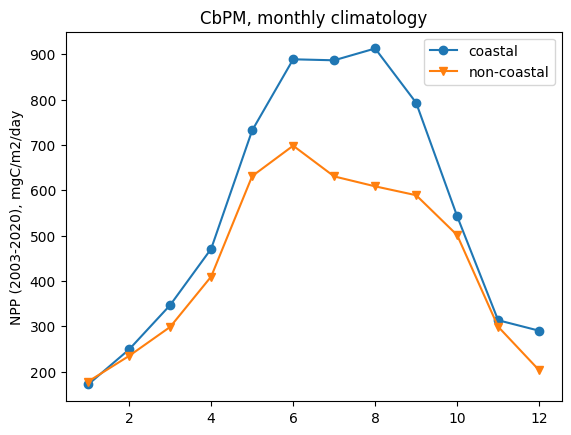

In [9]:
plt.plot(mon,npp_coastal,'o-',label='coastal')
plt.plot(mon,npp_noncoastal,'v-',label='non-coastal')
plt.legend()
plt.ylabel('NPP (2003-2020), mgC/m2/day')
plt.title('CbPM, monthly climatology')
#
# write out a table
df = pd.DataFrame([npp_coastal.to_numpy(),npp_noncoastal.to_numpy()],columns=mon,index=['Coastal NPP','Non-Coastal NPP'])
df.to_csv('background_npp.csv')

In [10]:
# calculate the area element
xx,yy=np.meshgrid(x,y)
R = 6.37e6
dx = 0.16667/180*np.pi
dy = 0.16667/180*np.pi
cosy = np.cos(yy/180*np.pi)
da = (R*dx*cosy)*(R*dy)

In [11]:
# calculate the coastal area in m^2
tmp = d_coastal.to_numpy()*da
area_coastal = np.sum(tmp.flatten())
#
tmp = d_noncoastal.to_numpy()*da
area_noncoastal = np.sum(tmp.flatten())
#
print(f'coastal area is {area_coastal:.3} m2')
print(f'non-coastal area is {area_noncoastal:.3} m2')

coastal area is 2.37e+12 m2
non-coastal area is 1.76e+12 m2
